In [1]:
# Code source: Brian McFee
# License: ISC

# main reference
# https://librosa.org/doc/main/auto_examples/plot_vocal_separation.html

# other reference
# https://librosa.org/librosa_gallery/auto_examples/plot_vocal_separation.html

##################
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa

import librosa.display

In [2]:
import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

In [3]:
from scipy.io import wavfile

fs, data = wavfile.read('./문제3/문제3-3.wav')
y, sr = librosa.load('./문제3/문제3-3.wav', sr=fs)


# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

# Play back a 5-second excerpt with vocals
Audio(y, sr)

<ipython-input-3-138d8a10eab1>:3: WavFileWarning: Reached EOF prematurely; finished at 103724 bytes, expected 103732 bytes from header.
  fs, data = wavfile.read('./문제3/문제3-3.wav')


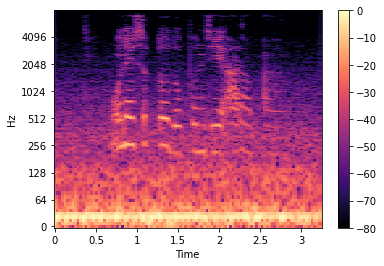

In [4]:
idx = slice(*librosa.time_to_frames([0, 5], sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

In [5]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(0.5, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimum
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [6]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

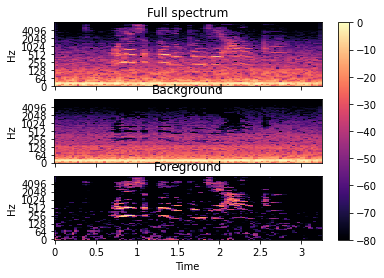

In [7]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground')
fig.colorbar(img, ax=ax)

In [8]:
y_foreground = librosa.istft(S_foreground * phase)
# Play back a 5-second excerpt with vocals
Audio(y_foreground, sr)

In [9]:
time = np.linspace(0, len(y_foreground)/sr, len(y_foreground)) # time axis

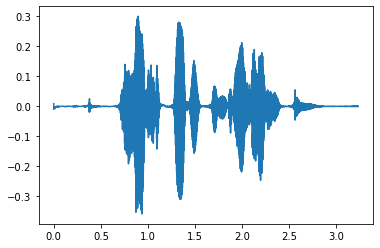

In [10]:
plt.plot(time, y_foreground)

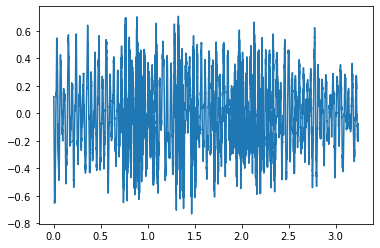

In [13]:

time = np.linspace(0, len(y)/sr, len(y)) # time axis
plt.plot(time, y)

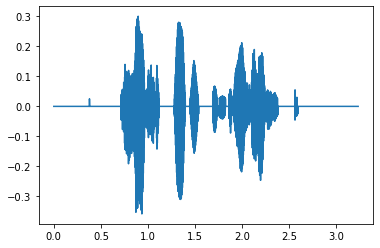

In [11]:
temp = y_foreground.copy()
for i, data in enumerate(y_foreground):
    if abs(data) < 0.025:
        temp[i] = 0


plt.plot(time, temp)
Audio(temp, sr)